In [1]:
#!/usr/bin/env python

from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=4)
cluster


cluster

In [2]:

client = Client(cluster)

client

Client Scheduler: tcp://10.32.15.48:40221 Dashboard: /user/0000-0001-7783-5629/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import xarray as xr
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import numpy as np                                                                                        
import zarr


In [4]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time
import gcsfs



In [5]:
import intake
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
cat = intake.Catalog(cat_url)


/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [6]:
cat.walk(depth=5)

{'ocean.sea_surface_height': name: sea_surface_height
 container: xarray
 plugin: ['zarr']
 description: sea-surface altimetry data from The Copernicus Marine Environment
 direct_access: forbid
 user_parameters: []
 metadata: 
   url: http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047
   tags: ['ocean', 'satellite']
 args: 
   urlpath: gcs://pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt
   storage_options: 
     token: anon
   consolidated: True, 'ocean.cesm_mom6_example': name: cesm_mom6_example
 container: xarray
 plugin: ['zarr']
 description: CESM MOM6 Ocean Model Example Data
 direct_access: forbid
 user_parameters: []
 metadata: 
   uploader_github: gustavo-marques
   uploader_email: gmarques@ucar.edu
   url: https://github.com/NCAR/MOM6-cases
   tags: ['ocean', 'model']
 args: 
   urlpath: gcs://pangeo-data/MOM6.cesm
   storage_options: 
     token: anon
   cons

In [7]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds = cat["sea_surface_height"].to_dask()

In [8]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray

In [5]:
%time

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
gcs = gcsfs.GCSFileSystem(gcs=fs,check=False,create=False)

mapzarr = gcs.get_mapper('pangeo-data/eNATL60-BLBT02X-ssh')
ds = xr.open_zarr(mapzarr)



CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


In [6]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<chunksize=(240, 480), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(240, 480), meta=np.ndarray>
    sossheig              (time_counter, y, x) float32 dask.array<chunksize=(240, 240, 480), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:29 +0100
    descr

In [7]:
g = zarr.open_group(mapzarr)
g.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,fsspec.mapping.FSMap
No. members,8
No. arrays,7
No. groups,1
Arrays,"nav_lat, nav_lon, sossheig, time_centered, time_centered_bounds, time_counter, time_counter_bounds"
Groups,NATL60


In [8]:
g.sossheig.info

Name,/sossheig
Type,zarr.core.Array
Data type,float32
Shape,"(11688, 4729, 8354)"
Chunk shape,"(240, 240, 480)"
Order,C
Read-only,False
Compressor,"Blosc(cname='snappy', clevel=6, shuffle=AUTOSHUFFLE, blocksize=0)"
Store type,fsspec.mapping.FSMap
No. bytes,1846987597632 (1.7T)
Chunks initialized,15919/17640


In [9]:
ds.sossheig.encoding

{'chunks': (240, 240, 480),
 'compressor': Blosc(cname='snappy', clevel=6, shuffle=AUTOSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32'),
 'coordinates': 'time_centered'}

In [10]:
%%time

lat=ds['nav_lat']
lon=ds['nav_lon']
 
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]

print(jmin,jmax,imin,imax)

2233 2634 3478 3780
CPU times: user 13 s, sys: 1.43 s, total: 14.5 s
Wall time: 4min 25s


In [11]:
time=ds['time_counter']
time.shape

(11688,)

In [12]:
time.min()

<xarray.DataArray 'time_counter' ()>
array('2009-06-30T00:30:00.000000000', dtype='datetime64[ns]')

In [13]:
time.max()

<xarray.DataArray 'time_counter' ()>
array('2010-10-29T23:30:00.000000000', dtype='datetime64[ns]')

In [14]:
with np.printoptions(threshold=np.inf):
    print(time[::12].values)

['2010-01-19T00:30:00.000000000' '2010-01-19T12:30:00.000000000'
 '2010-05-25T00:30:00.000000000' '2010-05-25T12:30:00.000000000'
 '2010-07-08T00:30:00.000000000' '2010-07-08T12:30:00.000000000'
 '2009-07-06T00:30:00.000000000' '2009-07-06T12:30:00.000000000'
 '2010-03-27T00:30:00.000000000' '2010-03-27T12:30:00.000000000'
 '2010-10-28T00:30:00.000000000' '2010-10-28T12:30:00.000000000'
 '2009-12-26T00:30:00.000000000' '2009-12-26T12:30:00.000000000'
 '2010-05-14T00:30:00.000000000' '2010-05-14T12:30:00.000000000'
 '2009-12-17T00:30:00.000000000' '2009-12-17T12:30:00.000000000'
 '2010-06-11T00:30:00.000000000' '2010-06-11T12:30:00.000000000'
 '2009-12-01T00:30:00.000000000' '2009-12-01T12:30:00.000000000'
 '2009-07-24T00:30:00.000000000' '2009-07-24T12:30:00.000000000'
 '2009-07-01T00:30:00.000000000' '2009-07-01T12:30:00.000000000'
 '2009-08-22T00:30:00.000000000' '2009-08-22T12:30:00.000000000'
 '2010-08-22T00:30:00.000000000' '2010-08-22T12:30:00.000000000'
 '2010-03-26T00:30:00.000

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [16]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1, aspect=50)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)


In [17]:
date='2009-10-01T00:30:00'
lat=ds.nav_lat.values
lon=ds.nav_lon.values


data=ds.sel(time_counter=date)['sossheig']


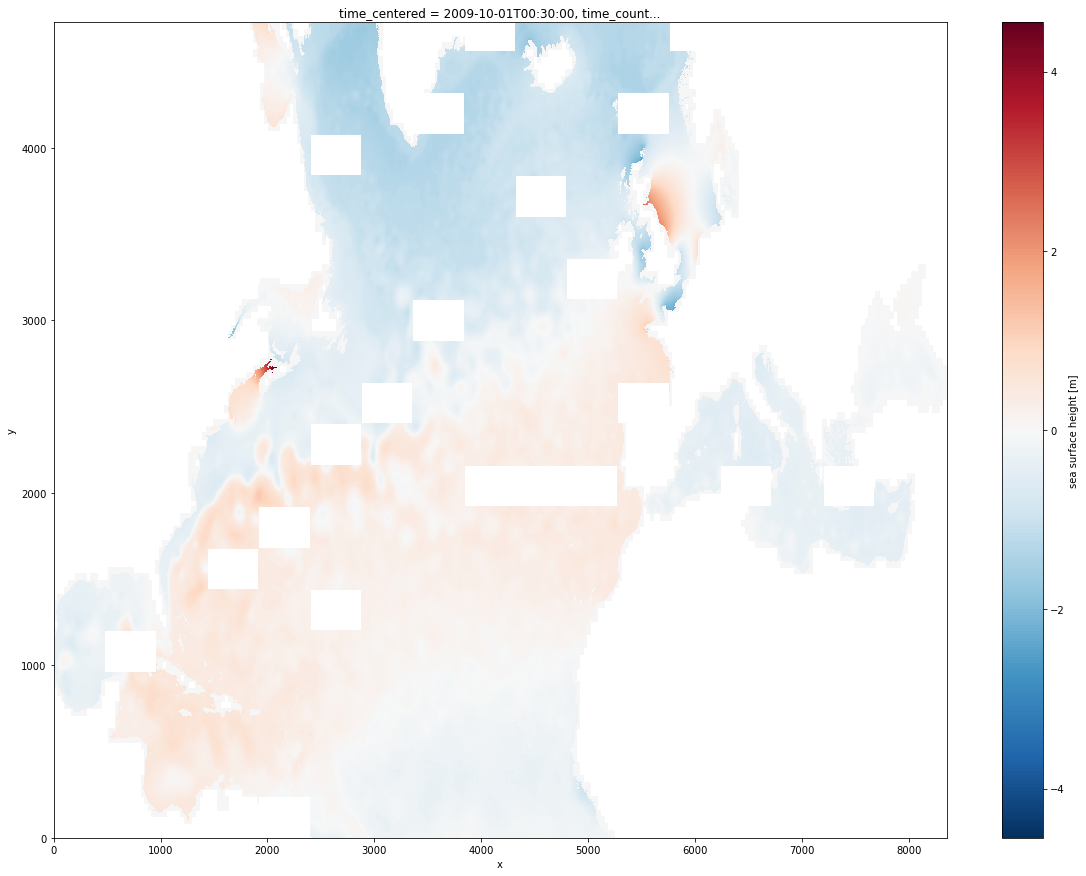

In [18]:
fig=plt.figure(figsize=(20,15))
data.plot()

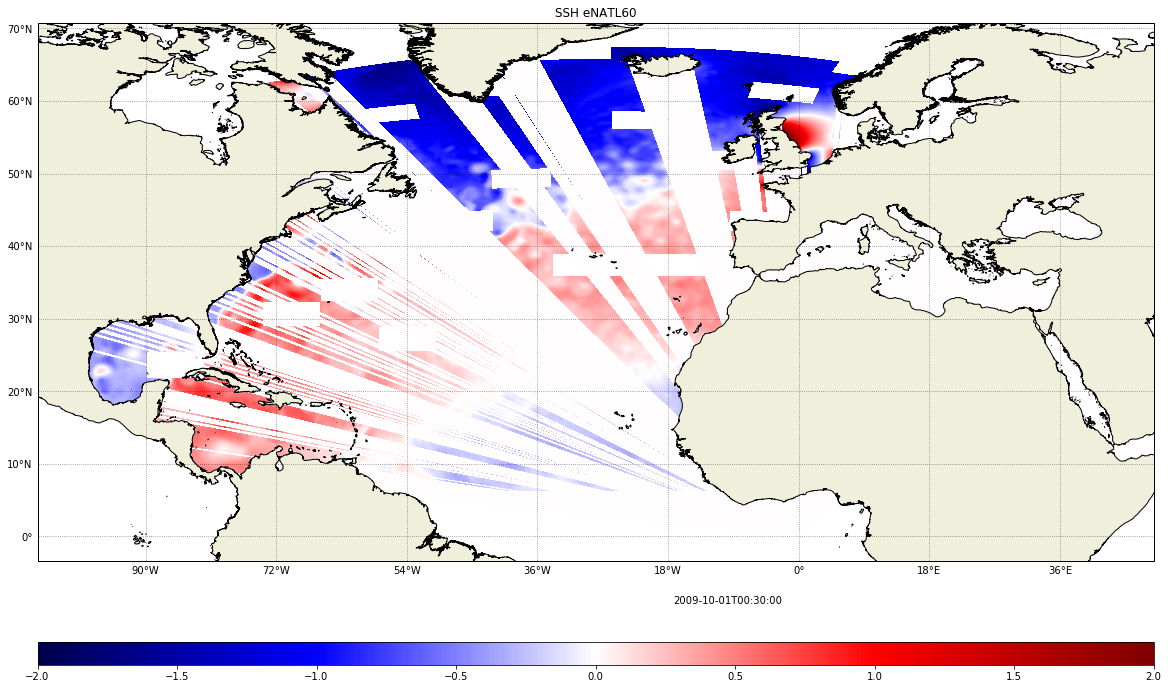

In [19]:
date='2009-10-01T00:30:00'
lat=ds.nav_lat.values
lon=ds.nav_lon.values


data=ds.sel(time_counter=date)['sossheig'].values

fig=plt.figure(figsize=(20,15))
plot_surf(111,data[0],lon,lat,-2,2,div_cmap,'SSH eNATL60',date)

In [20]:
client.close()

In [21]:
cluster.close()